<h1><span style="color:blue">The BLUE exercise</span></h1>

In this exercise, an experiment has been run to measure the brain response to oddly coloured fruit stimuli. Each item is either blue or pink, and is either an apple or a pear. The experiment has eight runs, with two conditions (estimated patterns) per run. The two factors have been balanced per run, and across the whole experiment, such that within each run one condition is blue and the other is pink, and one condition is apples and the the other is pears.

Two binary classifications have been run for each of 40 subjects, using leave-one-run-out cross-validation. The first classification decodes colour, and accuracy is significantly above chance. The second classification decodes fruit type, and **accuracy is significantly *below* chance.**. 

***How is this possible?***

***Change the analysis so that it no longer returns implausible below-chance accuracy.***

How could the experiment have been better designed to avoid this issue in the first place?

## Getting ready

Import the packages we might need:

In [1]:
import numpy as np              # This lets python process matrices, like Matlab
import matplotlib.pyplot as plt # This lets python plot graphs like Matlab
import seaborn as sns           # This provides another popular set of plotting functions
import scipy                    # This provides scientific capabilities like t-tests

# scikit-learn is the major library for machine learning in Python:
import sklearn as skl
from sklearn import preprocessing         # includes LabelEncoder, OneHotEncoder, StandardScaler...
from sklearn import model_selection       # includes StratifiedKFold, LeaveOneGroupOut...
from sklearn import linear_model          # includes LogisticRegression, RidgeClassifier...
from sklearn import svm                   # includes SVC, NuSVC & LinearSCV...
from sklearn import discriminant_analysis # includes LinearDiscriminantAnalysis
from sklearn import metrics               # includes roc_auc_score...
from sklearn import pipeline              # includes make_pipeline
from sklearn import inspection            # includes DecisionBoundaryDisplay

Set the random number generator:

In [2]:
np.random.seed(1)

## Simulate some data from a 2 x 2 design:

The factors are colour (blue, pink) and fruit (apple, pear).
There are 8 runs, and each run has two patterns.
The factors are counterbalanced so that the patterns in each run correpond to one sample of each colour, and one sample of each fruit.
Across the whole experiment, there are equal numbers of patterns evoked by blue apples, blue pears, pink apples, and pink pairs (4 of each)
I.e. in four runs the patterns correspond to "blue apple" and "pink pear"; in four runs the patterns correspond to "pink apple" and "blue pear"

For simplicity we'll only consider 2 voxels:

In [3]:
npeople = 40 # number of participants

nruns= 8 # number of runs

# dict containing mean activation pattern in response to each stimulus attribute:
mu = {
    'blue': np.array([-1, 1]), 
    'pink': np.array([1, -1]), 
    'apple':np.array([1 , 1]),
    'pear': np.array([1,  1]) 
}

voxel_covariance = np.diag([1,1]) + 1 # voxel covariance: independent noise per voxel plus some covariance

data = [] # list of pattern matrices (one per participant)

for p in np.arange(npeople):
    
    data_per_run    = [] # list of pattern matrices     (one for each run)
    colours_per_run = [] # list of colour label vectors (one for each run)
    fruits_per_run  = [] # list of fruit  label vectors (one for each run)
    for r in np.arange(nruns):
        if np.mod(r,2) == 0: # stimulus pairs alternate across runs
            colour1='blue'; fruit1='apple'
            colour2='pink'; fruit2='pear'
        else:
            colour1='pink'; fruit1='apple'
            colour2='blue'; fruit2='pear'
        
        colour_labels = [colour1] + [colour2];
        fruit_labels  = [fruit1]  + [fruit2];
        # sample activation pattern in response to each stimulus type:
        pattern1 =  np.random.multivariate_normal(mu[colour1]+mu[fruit1], voxel_covariance, size=1)
        pattern2 =  np.random.multivariate_normal(mu[colour2]+mu[fruit2], voxel_covariance, size=1)
        data_matrix  =  np.concatenate((pattern1, pattern2))
        
        data_per_run.append   ( data_matrix ) 
        colours_per_run.append( colour_labels ) 
        fruits_per_run.append ( fruit_labels ) 
    
    # concatenate runs for this participant
    data.append( np.concatenate(data_per_run, axis = 0) )

# same for all particiapnts:
colours =     np.concatenate(colours_per_run, axis = 0) 
fruits =      np.concatenate(fruits_per_run,  axis = 0) 
run_indices = np.concatenate([[i] * 2 for i in range(nruns)]) 
print('Colour labels per pattern:', colours)
print('\nFruit labels per pattern:', fruits)
print('\nRun indices per pattern:', run_indices)

Colour labels per pattern: ['blue' 'pink' 'pink' 'blue' 'blue' 'pink' 'pink' 'blue' 'blue' 'pink'
 'pink' 'blue' 'blue' 'pink' 'pink' 'blue']

Fruit labels per pattern: ['apple' 'pear' 'apple' 'pear' 'apple' 'pear' 'apple' 'pear' 'apple'
 'pear' 'apple' 'pear' 'apple' 'pear' 'apple' 'pear']

Run indices per pattern: [0 0 1 1 2 2 3 3 4 4 5 5 6 6 7 7]


\
Plot the data for the first two voxels of the first participant:

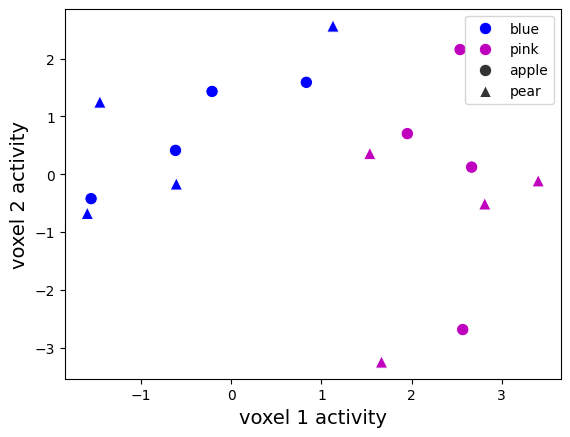

In [4]:
ax = sns.scatterplot(x = data[0][:,0], y = data[0][:,1], hue = colours, style = fruits, 
                     palette = ['b','m'], markers = ['o','^'], s = 80);
ax.set_xlabel('voxel 1 activity', fontsize = 14);
ax.set_ylabel('voxel 2 activity', fontsize = 14);

\
Specify the pre-processing, classification pipeline, and leave-one-run-out cross-validation scheme:

In [5]:
scaler = skl.preprocessing.StandardScaler()
SVM    = skl.svm.LinearSVC(dual='auto')
pipe   = skl.pipeline.make_pipeline(scaler, SVM)
logo   = skl.model_selection.LeaveOneGroupOut()

\
Classify colour for each participant:

In [6]:
colour_accuracy = np.full(npeople, np.nan)
for p in np.arange(npeople):
    accuracy_per_fold = skl.model_selection.cross_val_score(pipe, data[p], colours, groups = run_indices, cv = logo, scoring = 'balanced_accuracy')
    colour_accuracy[p] = np.mean(accuracy_per_fold)
    #print("Participant ", p, ": Accuracy per fold: ", accuracy_per_fold, "Mean accuracy (for random data):", colour_accuracy[p])

\
Run a one-sample t-test across participants and find significant discrimination of colours:

In [7]:
result = scipy.stats.ttest_1samp(colour_accuracy, 0.5, alternative = 'two-sided')
print("Mean accuracy of colour classification across participants:", np.mean(colour_accuracy))
print(f't({result.df}) = {result.statistic:.2f}; p = {result.pvalue:.2e}')

Mean accuracy of colour classification across participants: 0.9125
t(39) = 33.21; p = 3.24e-30


\
Now classify fruit for each participant:

In [8]:
fruit_accuracy = np.full(npeople, np.nan)
for p in np.arange(npeople):
    accuracy_per_fold = skl.model_selection.cross_val_score(pipe, data[p], fruits, groups = run_indices, cv = logo, scoring = 'balanced_accuracy')
    fruit_accuracy[p] = np.mean(accuracy_per_fold)
    #print("Participant ", p, ": Accuracy per fold: ", accuracy_per_fold, "Mean accuracy (for random data):", fruit_accuracy[p])

\
Run a one-sample t-test across participants and find **significantly *below chance* classification accuracy** for fruits:

In [9]:
result = scipy.stats.ttest_1samp(fruit_accuracy, 0.5, alternative = 'two-sided')
print("Mean accuracy of fruit classification across participants:", np.mean(fruit_accuracy))
print(f't({result.df}) = {result.statistic:.2f}; p = {result.pvalue:.2e}')

Mean accuracy of fruit classification across participants: 0.3828125
t(39) = -4.00; p = 2.72e-04


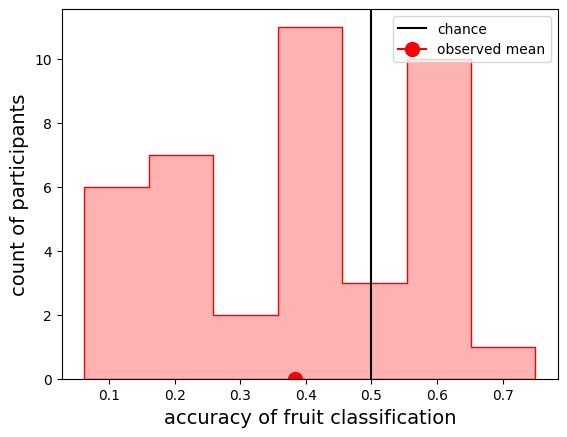

In [10]:
ax = sns.histplot(fruit_accuracy, element = 'step', alpha = 0.3, color = 'r')
ax.set_xlabel('accuracy of fruit classification', fontsize = 14)
ax.set_ylabel('count of participants',            fontsize = 14)
lh = ax.axvline(0.5, color = 'k', label = 'chance')
mh = ax.plot(np.mean(fruit_accuracy), 0, marker = 'o', color = 'r', markersize = 10, label = 'observed mean')
ax.legend();

## Questions:
 - Significantly below-chance performance for leave-one-run-out cross-validation shouldn't be possible, right??
 - How has this happened?
 - Can you change the analysis to get a classification score that's no longer significantly below chance?

## Hints:
- Think carefully about how the stimulus features are counter-balanced across the experiment
- Think about the choice of cross-validation partitions